In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel
from seisfwi.survey import Survey, Source, Receiver, GenericCable
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss

from seisfwi.utils import wavelet, moment_tensor, plot_data, plot_sg, timer, plot_misfit, load_misfit, smooth2d

## Working path

In [3]:
!mkdir 02-FWI-DAS

mkdir: cannot create directory ‘02-FWI-DAS’: File exists


### Parameters for elastic model

In [4]:
ox = 0.0
oz = 0.0
nx = 501
nz = 261
dx = 6.25
dz = 6.25

nt = 2000
dt = 0.002
f0 = 8.0
amp = 1e7

In [5]:
# True model for modeling obs data
vp_obs = np.load('../models/Marmousi2/Marmousi-Vp-13601x2801-1.25m.npy').T
vs_obs = np.load('../models/Marmousi2/Marmousi-Vs-13601x2801-1.25m.npy').T
rho_obs = np.load('../models/Marmousi2/Marmousi-Rho-13601x2801-1.25m.npy').T

# cut the model
vp = vp_obs[200:1505:5, 3000:5505:5].astype(np.float32)
vs = vs_obs[200:1505:5, 3000:5505:5].astype(np.float32)
rho = rho_obs[200:1505:5, 3000:5505:5].astype(np.float32)


(261, 501)


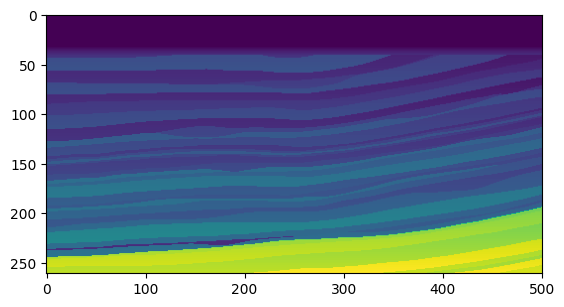

In [6]:
print(vp.shape)
plt.imshow(vp)

In [7]:
# Create a elastic model object
model = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs, rho = rho, free_surface=True, nabc=20)
model2 = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs, rho = rho, free_surface=False, nabc=20)

model

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2619.12 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :     0.00 -  1149.73 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1010.00 -  2258.91 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: True
  Absorbing layers: 20

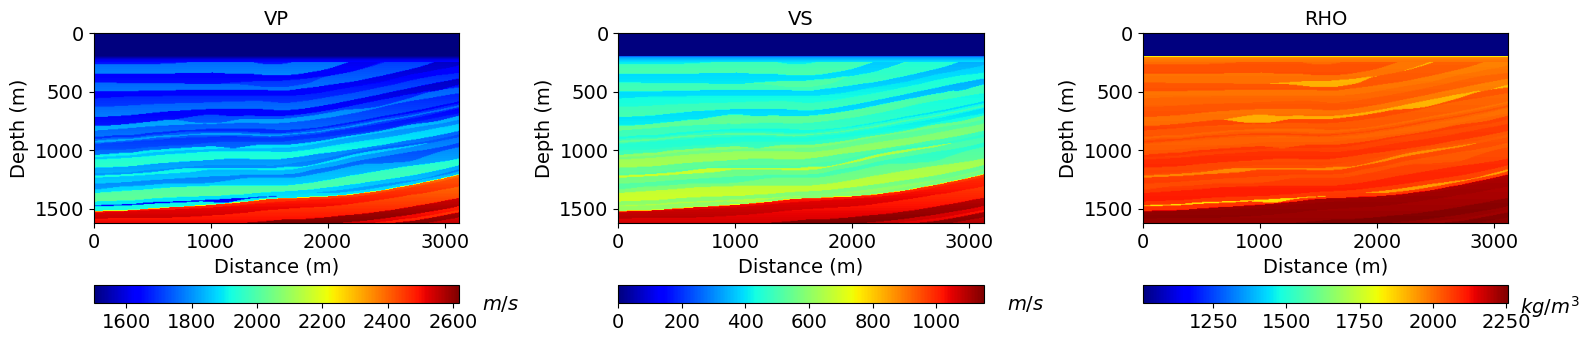

In [8]:
cmap_range={'vp': (1400, 2600), 'vs': (0, 1200), 'rho': (1600, 2250)}

model.plot()

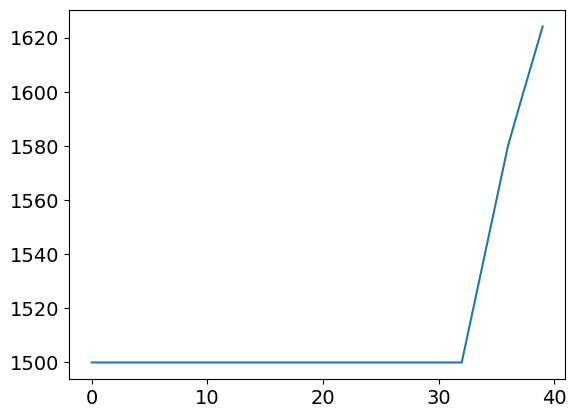

In [9]:
plt.plot(vp[:40,100])

### Seismic Source 

In [10]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(24):
    source.add_source([125 * isrc + 125, dx], wvlt, 'pr')

source

Seismic Source:
  Source wavelet: 2000 samples at 2.00 ms
  Source number : 24
  Source types  : ['pr']
  Source x range: 125.00 - 3000.00 m
  Source z range:   6.25 -   6.25 m

### Set Receiver, Survey, and Modeling

In [11]:
# set trajectory
traj = np.array([[1500, 0.0, 30.0],[1500, 0.0, 500.0], [1500, 0.0, 1000.0],[1550, 0.0, 1100.0], [1650, 0.0, 1200.0], [1800, 0.0, 1300.0], [2000, 0.0, 1400.0]])

# set the cable
chann_len = 10.0
chann_num = 165
gauge_len = 10.0

cable = GenericCable(traj, chann_len, chann_num, gauge_len)
cable

Last channel length must be between 5.0 and 1622.1091166354774 m, it is 1655.0 m
Change the channel number to 162 to make sure the last channel ends at the end of the cable


DAS Cable Information: 
  Cable total length: 1627.11 m 
  Channel coverage: 5.00 - 1625.00 m 
  Channel interval: 10.00 m 
  Channel number: 162 
  Gauge length: 10.00 m 
  Max channel length error: 0.2676 m 
  Max  gauge  length error: 0.0595 m 


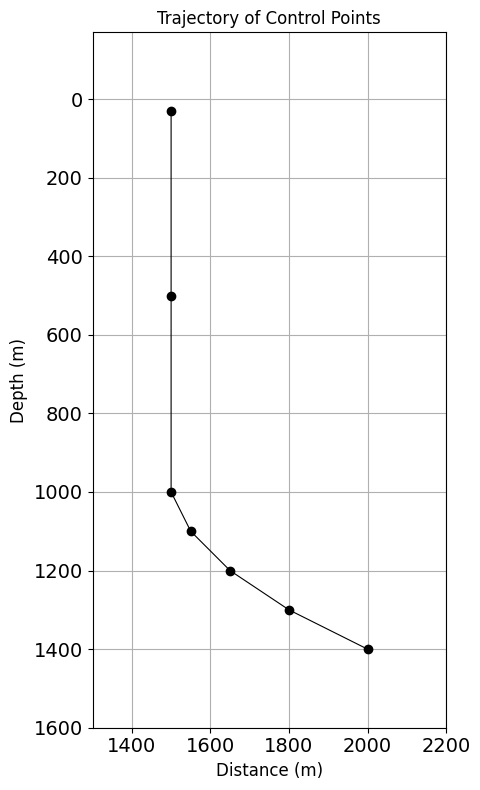

In [12]:
# plot provided trajectory
cable.plot_traj()


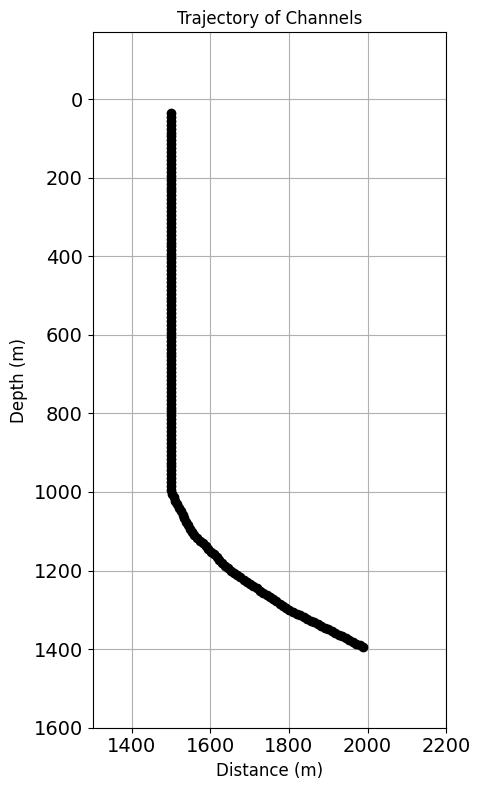

In [13]:
# plot channel location
cable.plot_channel()

In [14]:
# Create a set of seismic receiver
das = Receiver(nt = nt, dt = dt)

das.add_cable(cable)

  DAS cable is added to the survey with 163 unique receivers


In [15]:
# Note: for DAS modeling, we have to set interpolation to be True
survey = Survey(source=source, receiver=das, device='cuda', gpu_num=4, reciprocity=False, simultaneous=False, interpolation=True)

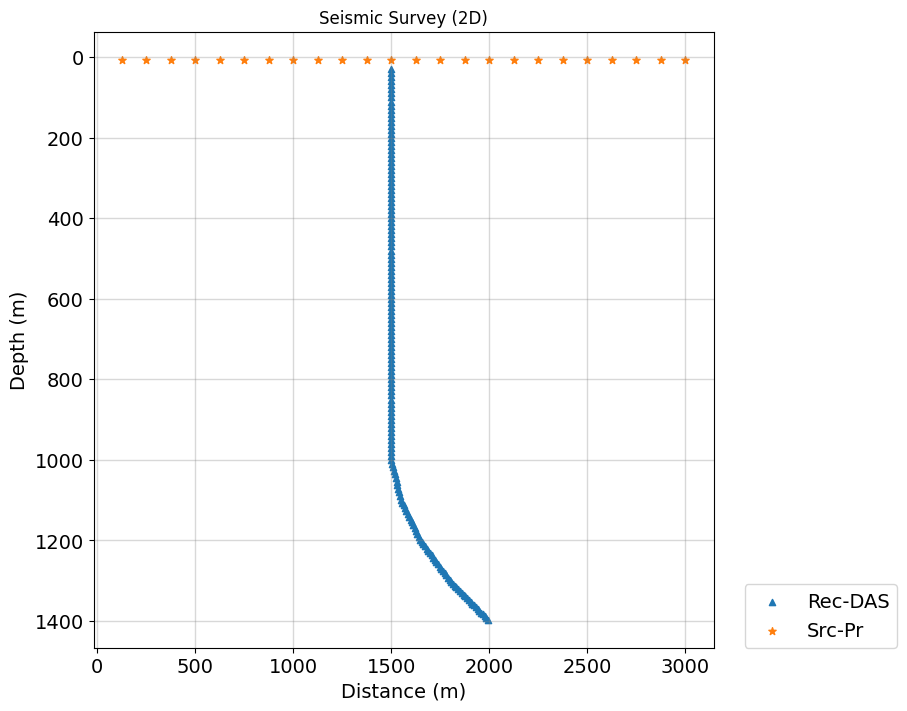

In [16]:
survey.plot()

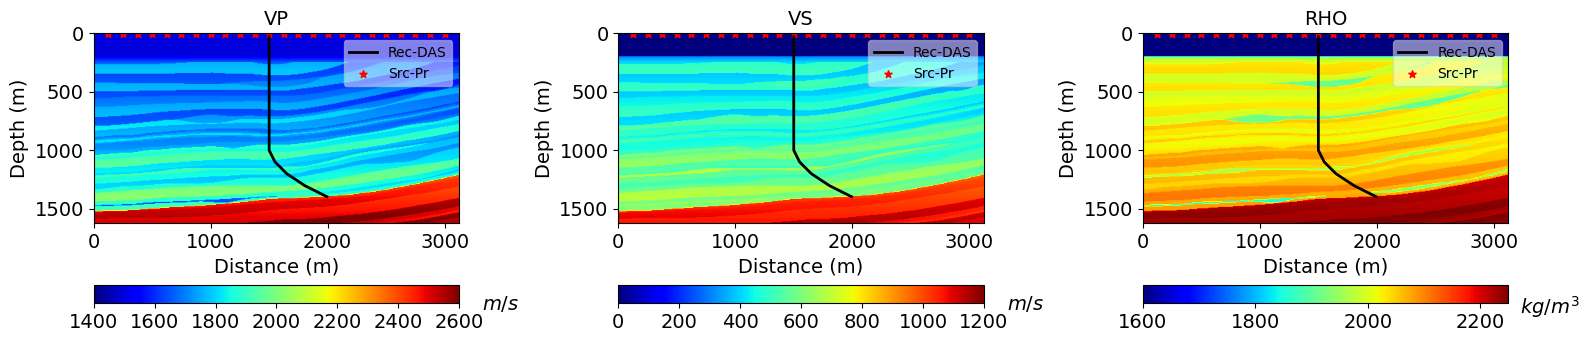

In [37]:
model.plot(survey, cmap_range=cmap_range, save_path='./02-FWI-DAS/marmousi-survey.png')

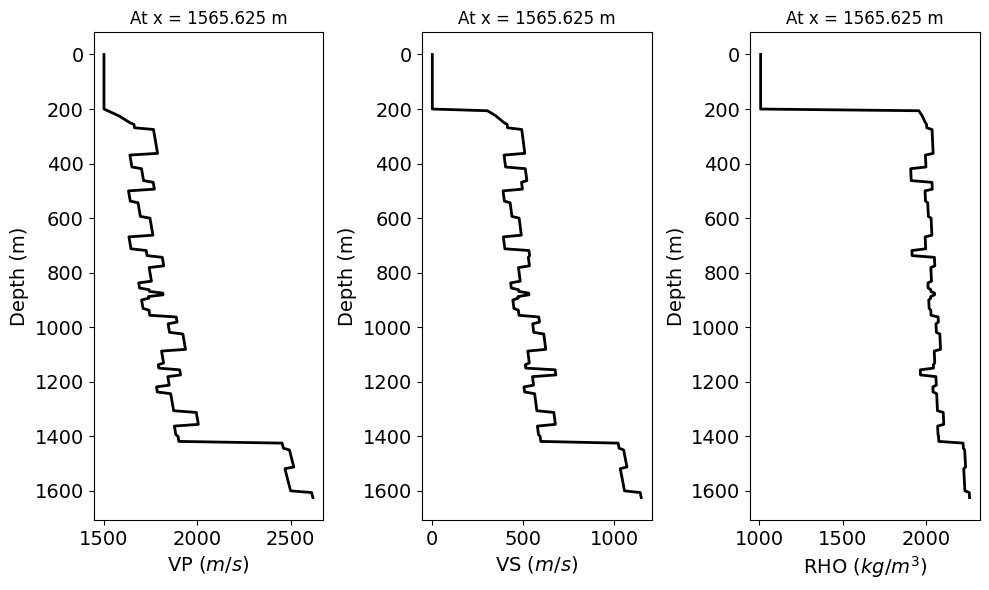

In [18]:
model.plot_well_log()

In [19]:
F = ElasticPropagator(model, survey)

Survey analysis completed: legal survey


In [20]:
dobs = F(model)

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/deepwave/common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 8.0, a minimum velocity of 0.0, and a grid cell spacing of 6.25, there are only 0.0.
  warnings.warn("At least six grid cells per wavelength is "


In [21]:
dobs

Seismic Data:
  Source number : 24
  Receiver number : 163
  Time samples : 2000 samples at 2.00 ms

### Check DAS data

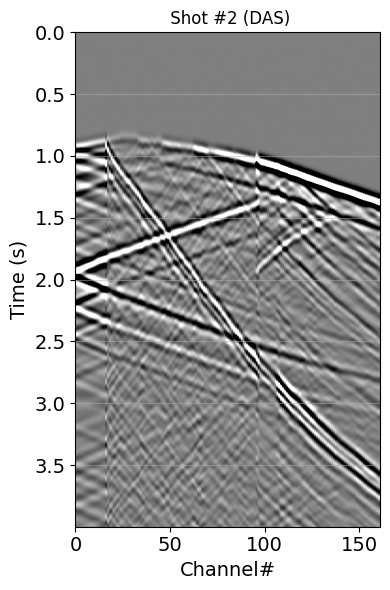

In [22]:
#  Vz data
dobs.plot(shotid=2, comp=['das'], clip=98)

In [23]:
# set fwi model
# Initial model for inversion

# MUST BE very careful here!!
vp_int = np.copy(vp)
vs_int = np.copy(vs)
rho_int = np.copy(rho)

nmask = 40
vp_int[nmask:, :] = smooth2d(vp_int[nmask:, :], 15, 15)
vs_int[nmask:, :] = smooth2d(vs_int[nmask:, :], 10, 10)
rho_int[nmask:, :] = smooth2d(rho_int[nmask:, :], 10, 10)

# set the gradient mask to exclude the water layers
grad_mask = np.ones((nz, nx))
grad_mask[:nmask,:] = 0.0
# grad_mask[nwater:nwater+10, :] = (np.repeat(np.linspace(0, 1, 10), nx)).reshape(10, nx)

In [24]:
model_fwi = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = vp_int, 
                     vs = vs_int, 
                     rho = rho_int, 
                     vp_grad = True, 
                     vs_grad = True,
                     rho_grad = True,
                     vp_bound = [1200, 3000],
                     vs_bound = [0, 1300],
                     rho_bound = [900, 2500],
                     free_surface=False,  # it doesn't matter 
                     nabc=20,
                     mask = grad_mask)

model_int = ElasticModel.clone(model_fwi)

model_fwi

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2539.51 m/s   , requires_grad = True, constrain bound: 1200 - 3000
  Model vs  :     0.00 -  1106.78 m/s   , requires_grad = True, constrain bound: -1e-07 - 1300
  Model rho :  1010.00 -  2245.93 kg/m^3, requires_grad = True, constrain bound: 900 - 2500
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: False
  Absorbing layers: 20

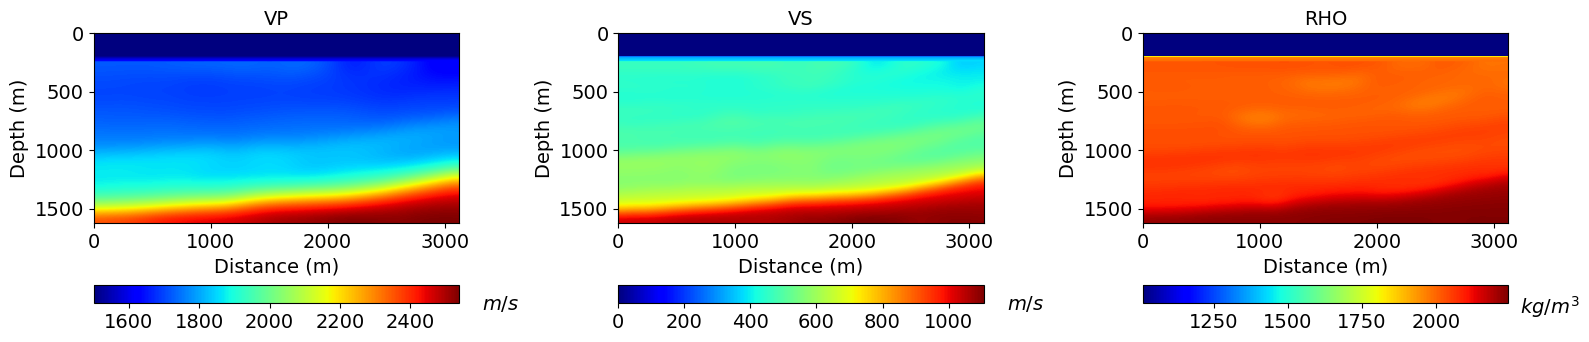

In [25]:
model_fwi.plot()

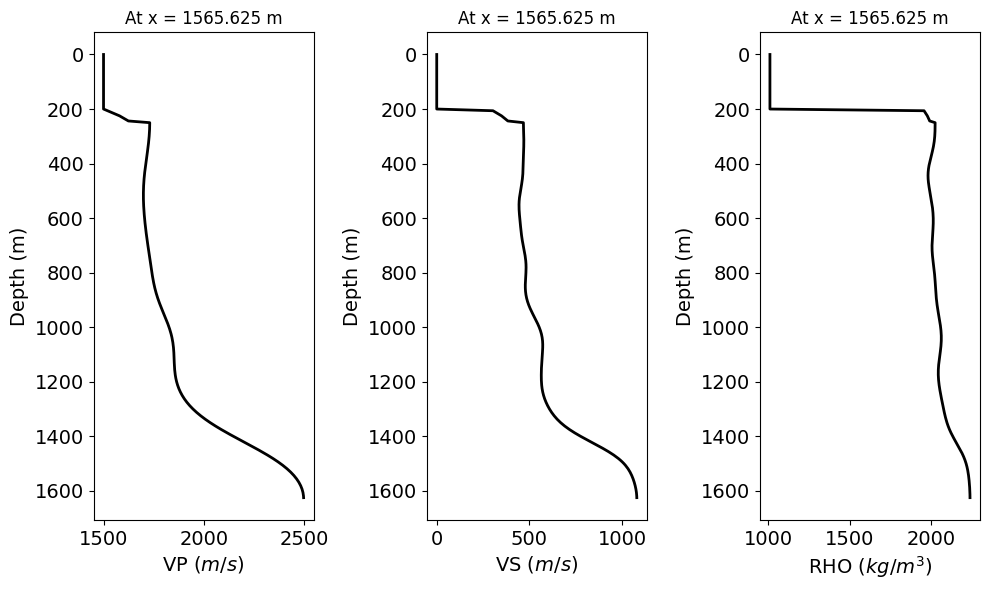

In [26]:
model_fwi.plot_well_log()

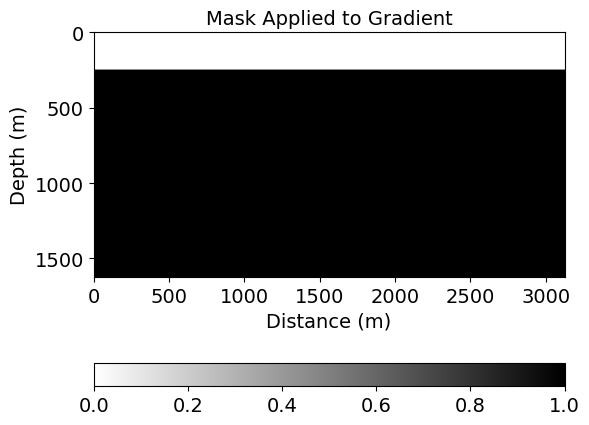

In [27]:
model_fwi.plot_mask()

In [28]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi.parameters(), 
                  lr = 1.0, 
                  max_iter = 50, 
                  tolerance_change = 1e-4, 
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'das': 1.0}

In [29]:
fwi = ElasticFWI(F, model_fwi, optimizer, misfit, dobs, weight)

In [30]:
fwi(nshot_per_gpu_per_batch = 6, max_iter=2, grad_scale = 20.0, grad_interval=2)

FWI: evaluating initial model ...
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       4.639619e+04                1         1.00e+00
     1       4.639515e+04                1         1.00e+00
     1       4.638881e+04                1         1.00e+00
     1       4.635385e+04                1         9.99e-01
     1       4.616175e+04                1         9.96e-01
     1       4.408760e+04                1         9.58e-01
     1       3.175337e+04                1         2.90e-01
     2       2.994922e+04                8         2.09e-01
     3       2.829017e+04                9         2.08e-01
     4       2.705491e+04               10        

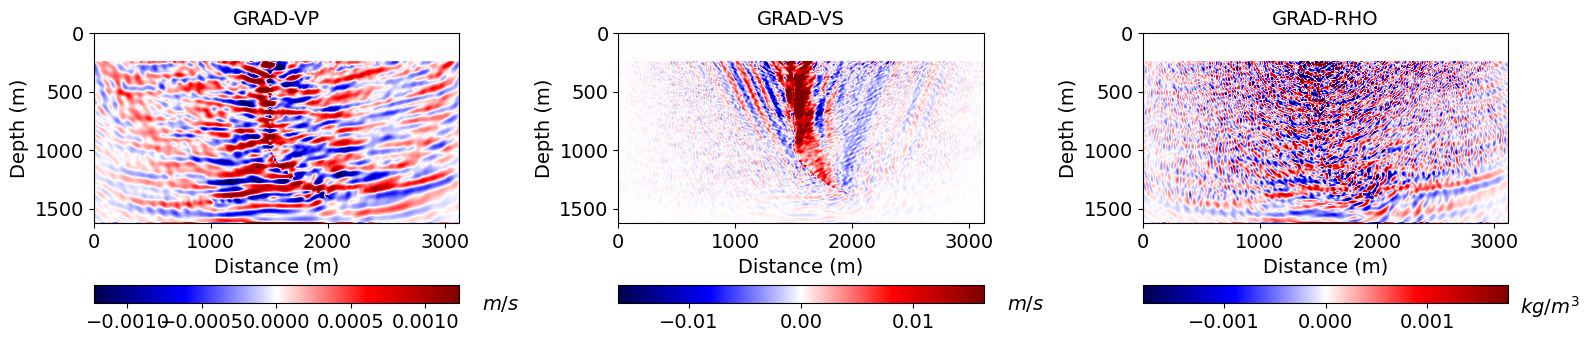

In [38]:
model_fwi.plot(grad=True, cmap='seismic', clip=99.)

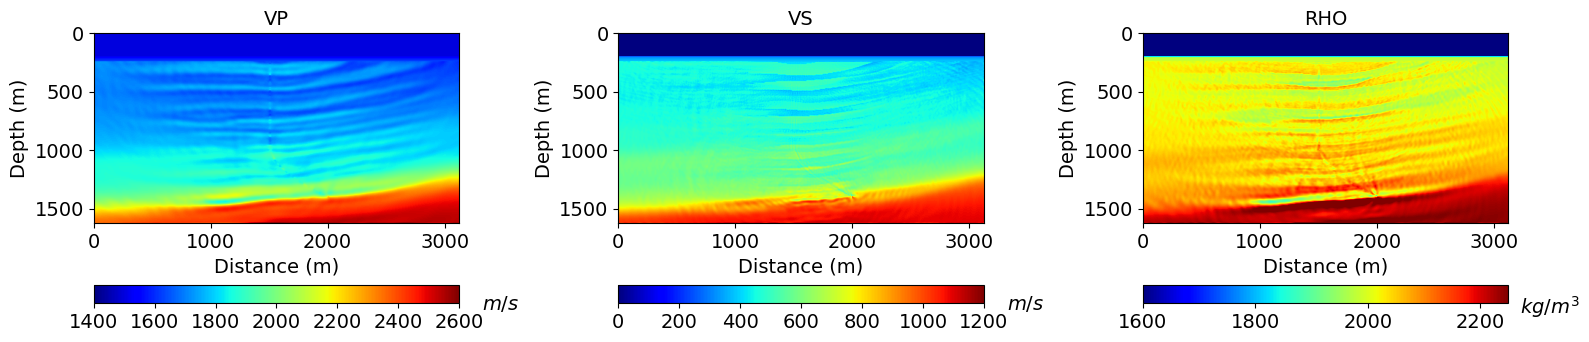

In [39]:
model_fwi.plot(cmap_range=cmap_range, save_path='./02-FWI-DAS/marmousi-fwi.png')

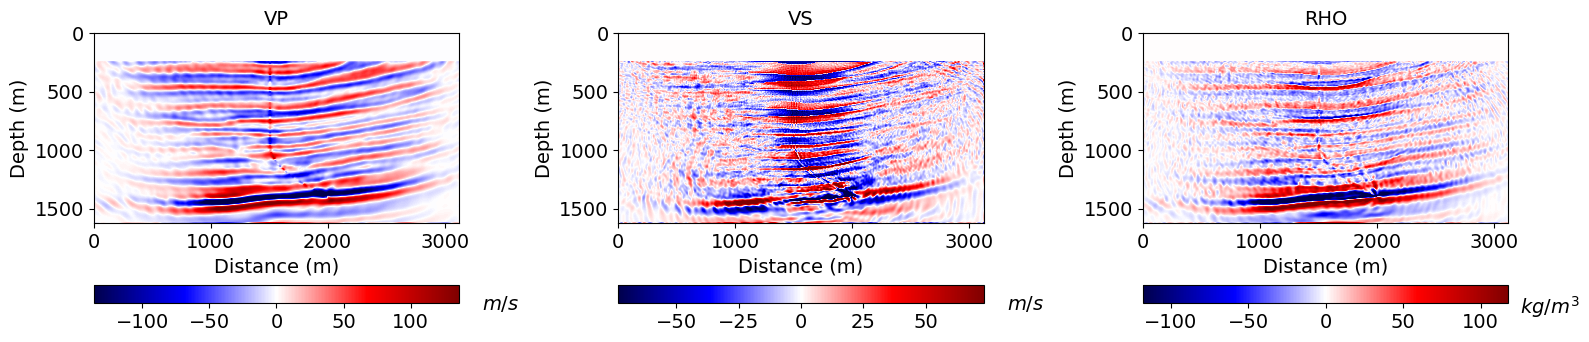

In [40]:
(model_fwi- model_int).plot(sym_clip=True, cmap='seismic', clip=99)

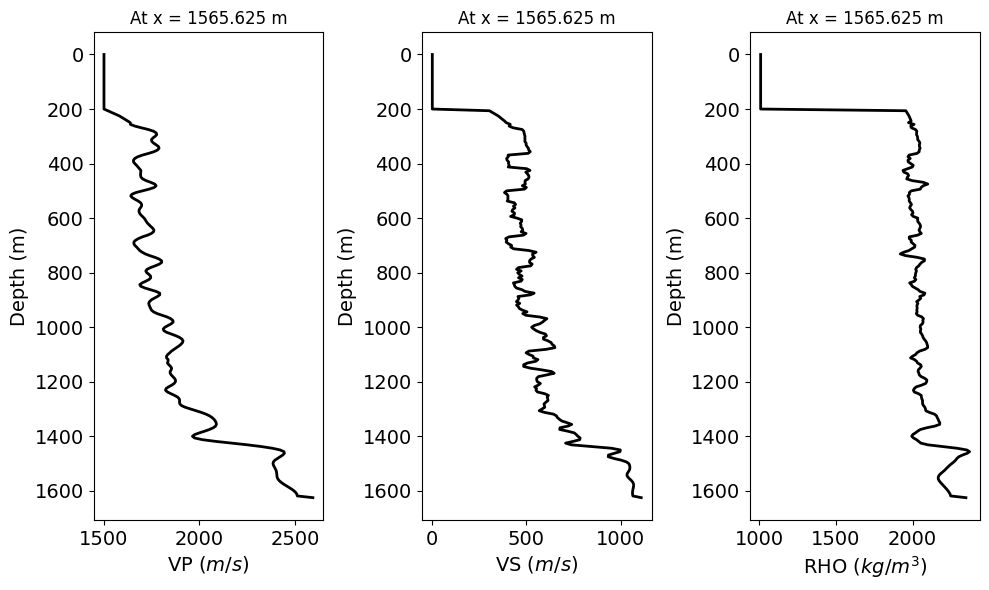

In [41]:
model_fwi.plot_well_log()

In [47]:
model.save('./02-FWI-DAS/model_true')
model_int.save('./02-FWI-DAS/model_int')
model_fwi.save('./02-FWI-DAS/model_fwi1')

### Next frequency band

In [48]:
f0 = 16.0

# Create a seismic sources
source2 = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(24):
    source2.add_source([125 * isrc + 125, dx], wvlt, 'pr')

source2

Seismic Source:
  Source wavelet: 2000 samples at 2.00 ms
  Source number : 24
  Source types  : ['pr']
  Source x range: 125.00 - 3000.00 m
  Source z range:   6.25 -   6.25 m

In [56]:
# Note: for DAS modeling, we have to set interpolation to be True
# Here, I use false for speed purposes
survey2 = Survey(source=source2, receiver=das, device='cuda', gpu_num=4, reciprocity=False, simultaneous=False, interpolation=False)

In [57]:
F2 = ElasticPropagator(model, survey2)

Survey analysis completed: legal survey


In [58]:
dobs2 = F2(model)

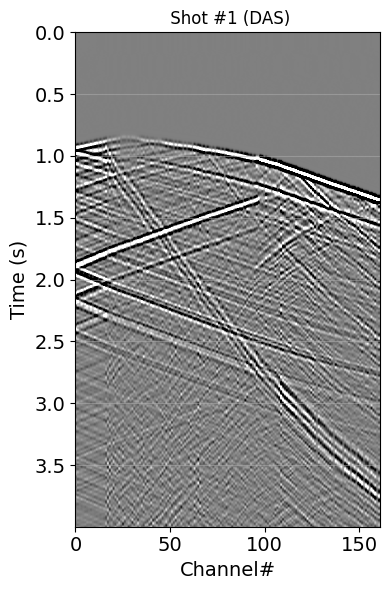

In [59]:
#  Vz data
dobs2.plot(shotid=1, comp=['das'], clip=98)

In [60]:
model_fwi2 = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = model_fwi.get_model('vp'), 
                     vs = model_fwi.get_model('vs'), 
                     rho = model_fwi.get_model('rho'), 
                     vp_grad = True, 
                     vs_grad = True,
                     rho_grad = True,
                     vp_bound = [1200, 3000],
                     vs_bound = [0, 1300],
                     rho_bound = [900, 2500],
                     free_surface=False, 
                     nabc=20,
                     mask = grad_mask)

model_int2 = ElasticModel.clone(model_fwi2)

model_fwi2

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2644.74 m/s   , requires_grad = True, constrain bound: 1200 - 3000
  Model vs  :     0.00 -  1133.41 m/s   , requires_grad = True, constrain bound: -1e-07 - 1300
  Model rho :  1010.00 -  2385.96 kg/m^3, requires_grad = True, constrain bound: 900 - 2500
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: False
  Absorbing layers: 20

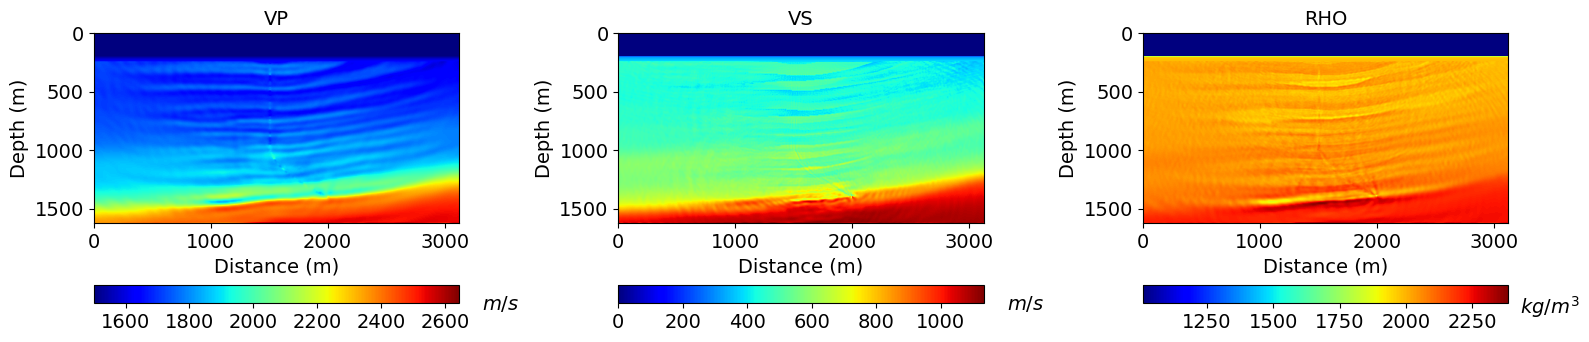

In [61]:
model_fwi2.plot()

In [64]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi2.parameters(), 
                  lr = 1.0, 
                  max_iter = 50, 
                  tolerance_change = 1e-4, 
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'das': 1.0}

In [65]:
fwi2 = ElasticFWI(F2, model_fwi2, optimizer, misfit, dobs2, weight)

In [66]:
fwi2(nshot_per_gpu_per_batch = 4, max_iter=2, grad_scale = 20.0, grad_interval=2)

FWI: evaluating initial model ...
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       3.488682e+04                1         1.00e+00
     1       3.488648e+04                1         1.00e+00
     1       3.488440e+04                1         9.99e-01
     1       3.487929e+04                1         9.97e-01
     1       3.483597e+04                1         9.78e-01
     1       3.462413e+04                1         8.79e-01
     2       3.282623e+04                7         5.45e-01
     3       3.094216e+04                8         4.06e-01
     4       2.680622e+04                9         4.45e-01
     5       3.209108e+04               10        

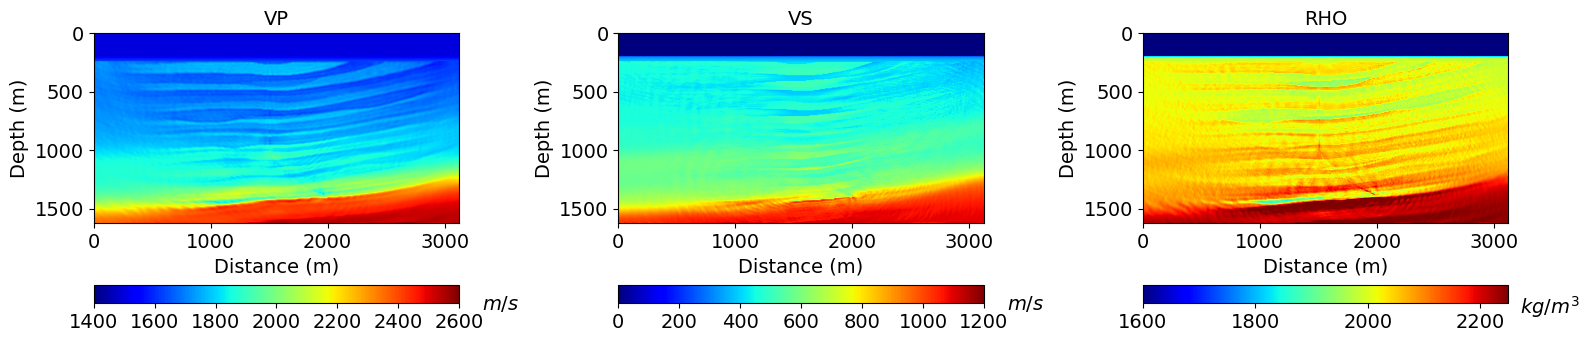

In [71]:
model_fwi2.plot(cmap_range=cmap_range, save_path='./02-FWI-DAS/marmousi-fwi-band2.png')

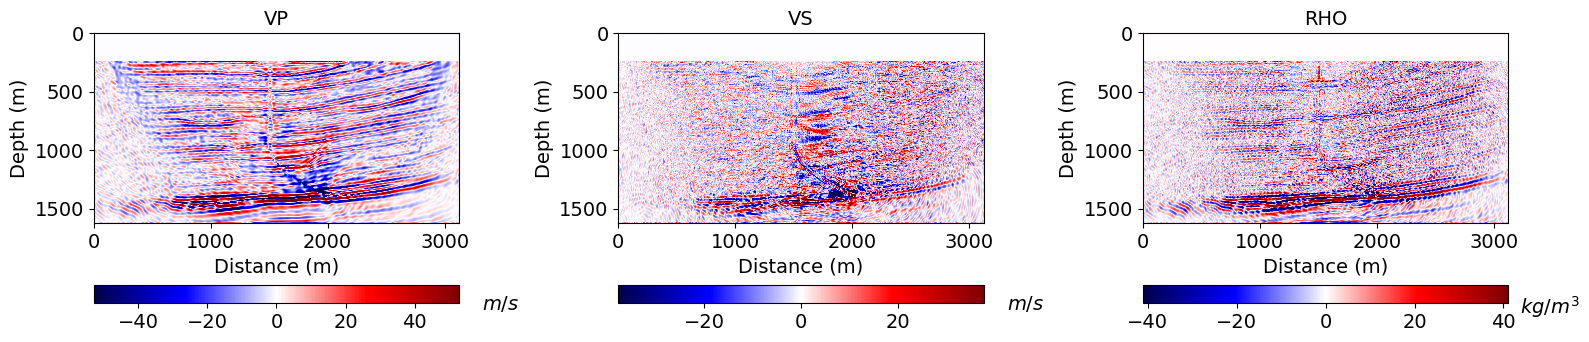

In [72]:
(model_fwi2- model_int2).plot(sym_clip=True, cmap='seismic', clip=99)

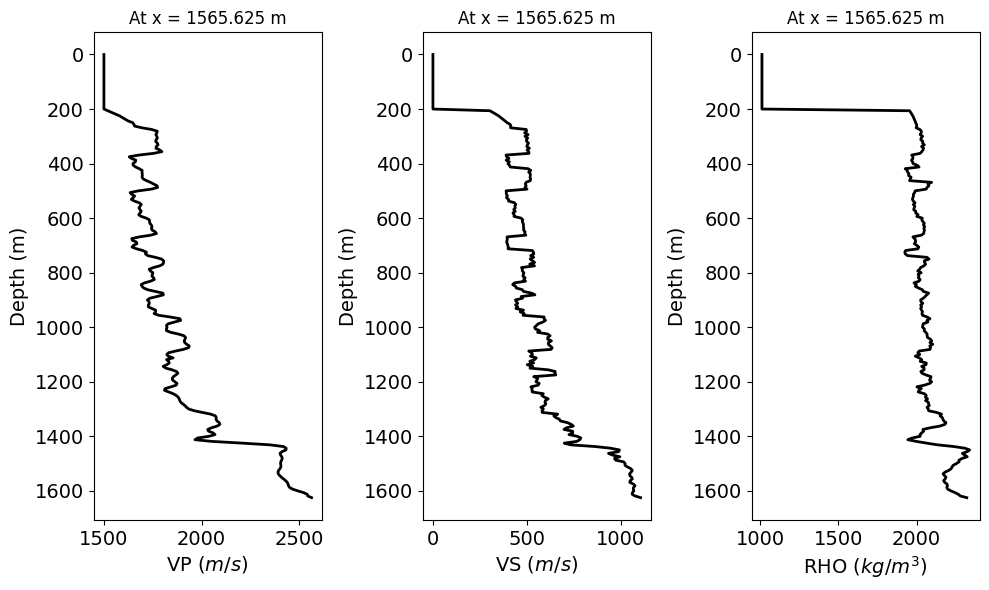

In [73]:
model_fwi2.plot_well_log()

In [74]:
model.save('./02-FWI-DAS/model_true')
model_int.save('./02-FWI-DAS/model_int')
model_fwi.save('./02-FWI-DAS/model_fwi1')
model_fwi2.save('./02-FWI-DAS/model_fwi2')

In [76]:
vp_true = model.get_model('vp')[:,nx//2]
vs_true = model.get_model('vs')[:,nx//2]
rho_true = model.get_model('rho')[:,nx//2]

vp_init = model_int.get_model('vp')[:,nx//2]
vs_init = model_int.get_model('vs')[:,nx//2]
rho_init = model_int.get_model('rho')[:,nx//2]

vp_fwi = model_fwi2.get_model('vp')[:,nx//2]
vs_fwi = model_fwi2.get_model('vs')[:,nx//2]
rho_fwi = model_fwi2.get_model('rho')[:,nx//2]

vp = [vp_true, vp_init, vp_fwi]
vs = [vs_true, vs_init, vs_fwi]
rho = [rho_true, rho_init, rho_fwi]

depth = model.z

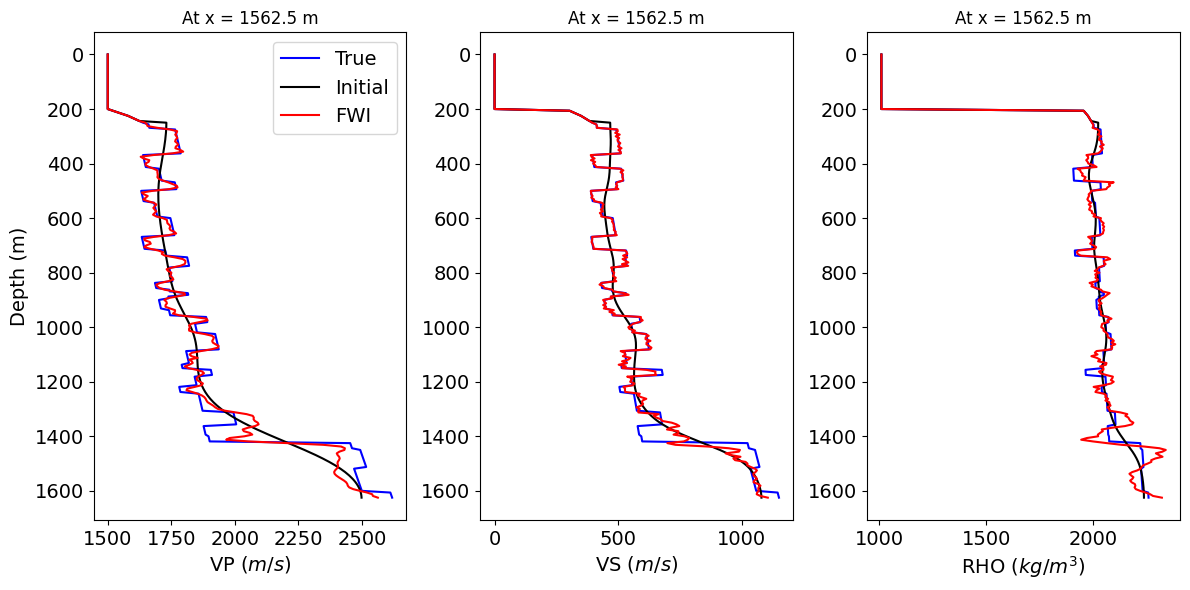

In [77]:
# set the default plot parameters


fontsize = 14
plt.rcParams.update(
    {
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
    }
)

units = {
    "vp": "m/s",
    "vs": "m/s",
    "rho": "kg/m^3",
}

x = nx//2 * dx

pars = ['vp', 'vs', 'rho']

fig = plt.figure(figsize=(12, 6))
for i, par in enumerate([vp, vs, rho]):
    ax = fig.add_subplot(1,3,i+1)
    plt.plot(par[0], depth, 'b-', linewidth = 1.5, label='True')
    plt.plot(par[1], depth, 'k-', linewidth = 1.5, label='Initial')
    plt.plot(par[2], depth, 'r-', linewidth = 1.5, label='FWI')
    plt.xlabel(pars[i].upper() + f' (${units[pars[i]]}$)')

    if i==0:
        plt.ylabel("Depth (m)")
    plt.gca().invert_yaxis()
    plt.title(f'At x = {x} m')
    
    if i == 0:
        plt.legend(loc='best')

plt.tight_layout()

plt.savefig('./02-FWI-DAS/marmousi-compare-well.png', dpi=300, bbox_inches='tight')

plt.show()